In [1]:
# reinstall numpy for flaml
!pip install "numpy<2.0.0" --force-reinstall

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [2]:
import numpy as np
np.__version__

'1.26.4'

In [3]:
! nvidia-smi

Wed Dec  3 15:21:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
! rm -rf cs589assignment3/
! git clone https://github.com/guanqun-yang/cs589assignment4.git cs589assignment3

Cloning into 'cs589assignment3'...
remote: Enumerating objects: 18, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 18 (from 1)
Receiving objects: 100% (18/18), 1.61 MiB | 4.65 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!pip uninstall transformers

Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Would remove:
    /usr/local/bin/transformers
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.12/dist-packages/transformers-4.57.3.dist-info/*
    /usr/local/lib/python3.12/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.57.3


In [6]:
! pip install transformers
! pip install datasets
! pip install seedir

  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)


In [7]:
!pip install flaml
from flaml import tune

In [8]:
import transformers
transformers.__version__

'4.57.3'

In [9]:
import os
import json
import math
import torch
import pickle
import string
import pathlib
import itertools
import time

import seedir as sd
import pandas as pd

from termcolor import cprint
from scipy.special import (
    expit,
    softmax
)
from collections import (
    defaultdict,
    Counter
)

from torch.nn import BCEWithLogitsLoss
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    RandomSampler,
    SequentialSampler
)

from tqdm import tqdm, trange
from sklearn.preprocessing import MultiLabelBinarizer

from datasets import (
    Dataset,
    load_dataset
)
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
)
from torch.optim import AdamW

In [10]:
#helper functions
def prepare_dataloader(encodings, labels, ids, batch_size=32):
    lst2arr = lambda lst: np.array(lst)[np.newaxis, :]

    input_ids, token_type_ids, attention_masks = [torch.tensor(np.hstack(lst2arr(v))) for v in encodings.values()]
    labels = torch.tensor(labels)
    ids = torch.tensor(ids)

    dataset = TensorDataset(input_ids, attention_masks, labels, token_type_ids, ids)
    sampler = RandomSampler(dataset)

    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)

    return dataloader


def evaluate_model(model, dataloader, verbose=False):
    model.eval()
    logits, trues, ids = list(), list(), list()
    with tqdm(total=len(dataloader), desc="Prediction" if verbose else None) as pbar:
        for batch in dataloader:
            batch_input_ids, batch_attention_masks, batch_labels, batch_token_type_ids, batch_ids = \
            [t.to(device) for t in batch]

            with torch.no_grad():
                output = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_masks)

                logits.extend(output.logits.detach().cpu().numpy())
                trues.extend(batch_labels.cpu().numpy())
                ids.extend(batch_ids.cpu().numpy().tolist())

                pbar.update(1)

    trues = [t == 1 for t in trues]

    return trues, logits, ids


def ndcg(ranking, topK=None):
    # when topK is None, the entire list is chosen
    # make sure the ranking contains numeric or boolean relevance
    assert all(rel * 0 == 0 for rel in ranking),\
    "make sure input array has only numeric or boolean types"

    # compute dcg
    dcg = 0
    for idx, rel in enumerate(ranking[:topK]):
        rank = idx + 1
        dcg += (2 ** rel - 1) / np.log2(rank + 1)

    # compute idcg
    idcg, max_rel = 0, max(ranking)
    rel_cnt = sum([math.isclose(rel, 0) == False for rel in ranking])
    for idx in range(min(rel_cnt, topK) if topK else rel_cnt):
        rank = idx + 1
        idcg += (2 ** max_rel - 1) / np.log2(rank + 1)

    score = dcg / idcg
    return score


def preprocess_text(text):
    return " ".join([token.lower().strip(string.punctuation) for token in text.split()])

In [11]:
# directory structure
cprint("directory structure:", "red")
sd.seedir("cs589assignment3", style='lines', itemlimit=10, depthlimit=2, exclude_folders=".git")

directory structure:
cs589assignment3/
└─python/
  ├─train.json
  ├─test.json
  └─val.json


In [12]:
# a glance at the data
df_dict = dict()
pd.options.display.max_columns = 5
for split in ["train", "val", "test"]:
    cprint(f"a sample of {split} split:", "red")
    df = pd.read_json(f"cs589assignment3/python/{split}.json", lines=True, orient="records")
    print(df.sample(n=5))

    df_dict[split] = df

a sample of train split:
                                               question            tags  name
4421  trying encode int base expected output mq give...        [string]  4421
3268  d array save grayscale image using scipy misc ...  [numpy, scipy]  3268
3012  trying use user registered signal order set de...         [flask]  3012
2427  part works try save image fails miserably gene...    [matplotlib]  2427
1784  downscale raster data x size x size enforcing ...  [numpy, scipy]  1784
a sample of val split:
                                              question                   tags  \
302  want align tabs panes inside ttk notebook rel ...  [python-2.7, tkinter]   
222  writing application collect udp messages proce...       [multithreading]   
509  obtain number overlapping regex matches using ...        [regex, string]   
448  currently building portfolio site client troub...               [django]   
152  trying create list string comma delimited valu...                 [list]  

In [13]:
# see all unique tags based on their frequency in the train.json
cprint("unique tags:", "red")
tags = list(itertools.chain(*df_dict["train"].tags.tolist()))
print(pd.DataFrame({"tag": tag, "count": Counter(tags)[tag]} for tag in set(tags)))

unique tags:
                       tag  count
0                    numpy    528
1                   opencv     46
2                algorithm     62
3               dictionary    159
4                   string    129
5                   scrapy     57
6              performance     77
7                 selenium     69
8               virtualenv     69
9   python-imaging-library     72
10         multiprocessing     67
11              python-3.x    347
12                    file     52
13                 tkinter    147
14                  arrays    109
15                   regex    110
16                 parsing     52
17              sqlalchemy     91
18          multithreading     71
19                 unicode     59
20                   scipy    184
21                 windows    124
22         python-requests     54
23                    list    207
24              matplotlib    423
25                   mysql     62
26              subprocess     81
27                     csv    116
2

In [14]:
n_label = 50
lang = "python"

# change the following parapeters as you like
n_epoch = 3
learning_rate = 5e-6
batch_size = 4

# for debugging
dataset_size = 100

In [15]:
data_path = pathlib.Path(f"cs589assignment3/{lang}")

data_files = {
    "train": str(data_path / "train.json"),
    "validation": str(data_path / "val.json"),
    "test": str(data_path / "test.json")
}

dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [16]:
# ################################### UNCOMMENT TO SAMPLE DATASET ####################################

# train_df = pd.DataFrame(dataset["train"])
# unique_tags = set(itertools.chain(*train_df.tags.tolist()))

# n_sample = int(dataset_size / len(unique_tags))
# train_dfs = [train_df[train_df.tags.apply(lambda x: tag in x)].sample(n=n_sample) \
#              for tag in unique_tags]

# dataset["train"] = Dataset.from_pandas(pd.concat(train_dfs, ignore_index=True))

# for split in ["validation", "test"]:
#     dataset[split] = dataset[split].select(np.arange(dataset_size))

# ###################################################################################################

In [17]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'tags', 'name'],
        num_rows: 4678
    })
    validation: Dataset({
        features: ['question', 'tags', 'name'],
        num_rows: 585
    })
    test: Dataset({
        features: ['question', 'tags', 'name'],
        num_rows: 585
    })
})


In [18]:
tokenization_option_dict = {"max_length": 32, "padding": "max_length", "truncation": True}

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_questions = list(dataset["train"]["question"])
val_questions = list(dataset["validation"]["question"])
test_questions = list(dataset["test"]["question"])

train_encodings = tokenizer(train_questions, **tokenization_option_dict)
val_encodings = tokenizer(val_questions, **tokenization_option_dict)
test_encodings = tokenizer(test_questions, **tokenization_option_dict)

encoder = MultiLabelBinarizer()
train_labels = encoder.fit_transform(dataset["train"]["tags"])
val_labels = encoder.transform(dataset["validation"]["tags"])
test_labels = np.zeros((dataset["test"].num_rows, n_label))

train_ids = dataset["train"]["name"]
val_ids = dataset["validation"]["name"]
test_ids = dataset["test"]["name"]

train_dataloader = prepare_dataloader(train_encodings, train_labels, train_ids, batch_size=batch_size)
val_dataloader = prepare_dataloader(val_encodings, val_labels, val_ids, batch_size=batch_size)
test_dataloader = prepare_dataloader(test_encodings, test_labels, test_ids, batch_size=batch_size)

# map index to tag
index2tag_dict = {idx: tag for idx, tag in enumerate(encoder.classes_)}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased",
      num_labels=n_label
  ).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# function for running trial
def run_trial(learning_rate, n_epoch):
  start_time = time.time()  # for wct calculation
  best_ndcg = 0.0

  # use the settings from hw3
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased",
      num_labels=n_label
  ).to(device)
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
       'weight_decay_rate': 0.01},
     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
       'weight_decay_rate': 0.0}
  ]
  criterion = BCEWithLogitsLoss()
  optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

  # training loop
  for epoch in trange(n_epoch, desc="Epoch"):
    model.train()
    train_loss, train_step = 0.0, 0
    #with tqdm(total=len(train_dataloader), desc=f"Epoch={epoch+1}, Training") as pbar:
    for batch in train_dataloader:
      batch_input_ids = batch[0].to(device)
      batch_attention_masks = batch[1].to(device)
      batch_labels = batch[2].to(device)
      batch_token_type_ids = batch[3].to(device)
      # batch_ids = batch[4]

      # forward
      outputs = model(
          input_ids = batch_input_ids,
          attention_mask = batch_attention_masks,
          token_type_ids = batch_token_type_ids
      )
      logits = outputs.logits # (B, 50)
      loss = criterion(logits, batch_labels.float())

      # backward
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()

      train_step += 1
      train_loss += loss.item()
      #pbar.update(1)

    # NDCG calculation after each epoch
    trues, val_logits, _ = evaluate_model(model, val_dataloader)

    ndcg_list = []
    for true, logit in zip(trues, val_logits):
      logit = np.array(logit)
      true = np.array(true)
      logit[true == 0] = 0  # remain true tags score only
      rel_dict = {index2tag_dict[idx]: logit[idx] for idx in np.flatnonzero(logit)}
      # boolean vector => tag list
      true_tags = encoder.inverse_transform(true[np.newaxis, :])[0]
      if len(true_tags) == 0:
        continue
      ranking = [rel_dict[tag] for tag in true_tags]
      ranking = expit(ranking)
      ndcg_list.append(ndcg(ranking))

    if ndcg_list:
      val_ndcg = sum(ndcg_list) / len(ndcg_list)
    else:
      val_ndcg = 0.0

    best_ndcg = max(best_ndcg, val_ndcg)

  wct = time.time() - start_time

  return best_ndcg, wct

In [21]:
# apply grid search
learning_rates = [1e-7, 1e-6, 1e-5]
epochs_list = [1, 2, 3, 4, 5]
grid_result = []

global_start = time.time()
for lr in learning_rates:
  for n_epoch in epochs_list:
    print(f"\====== Grid Search trial: lr={lr}, epochs={n_epoch} ======")
    best_ndcg, wct = run_trial(lr, n_epoch)

    wct_from_start = time.time() - global_start

    grid_result.append({
        "lr": lr,
        "epochs": n_epoch,
        "best_ndcg": best_ndcg,
        "wct": wct_from_start
    })

<>:9: SyntaxWarning: invalid escape sequence '\='
<>:9: SyntaxWarning: invalid escape sequence '\='
/tmp/ipython-input-219739549.py:9: SyntaxWarning: invalid escape sequence '\='
  print(f"\====== Grid Search trial: lr={lr}, epochs={n_epoch} ======")


\====== Grid Search trial: lr=1e-07, epochs=1 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 1/1 [01:32<00:00, 92.54s/it]


\====== Grid Search trial: lr=1e-07, epochs=2 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 2/2 [02:56<00:00, 88.15s/it]


\====== Grid Search trial: lr=1e-07, epochs=3 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 3/3 [04:12<00:00, 84.14s/it]


\====== Grid Search trial: lr=1e-07, epochs=4 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 4/4 [05:37<00:00, 84.38s/it]


\====== Grid Search trial: lr=1e-07, epochs=5 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [07:00<00:00, 84.12s/it]


\====== Grid Search trial: lr=1e-06, epochs=1 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 1/1 [01:23<00:00, 83.88s/it]


\====== Grid Search trial: lr=1e-06, epochs=2 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 2/2 [02:47<00:00, 83.93s/it]


\====== Grid Search trial: lr=1e-06, epochs=3 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 3/3 [04:11<00:00, 83.98s/it]


\====== Grid Search trial: lr=1e-06, epochs=4 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 4/4 [05:36<00:00, 84.23s/it]


\====== Grid Search trial: lr=1e-06, epochs=5 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [07:00<00:00, 84.06s/it]


\====== Grid Search trial: lr=1e-05, epochs=1 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 1/1 [01:24<00:00, 84.18s/it]


\====== Grid Search trial: lr=1e-05, epochs=2 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 2/2 [02:49<00:00, 84.76s/it]


\====== Grid Search trial: lr=1e-05, epochs=3 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 3/3 [04:12<00:00, 84.20s/it]


\====== Grid Search trial: lr=1e-05, epochs=4 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 4/4 [05:41<00:00, 85.33s/it]


\====== Grid Search trial: lr=1e-05, epochs=5 ======


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [06:58<00:00, 83.63s/it]


In [22]:
# check grid search ndcg score
df_grid = pd.DataFrame(grid_result)
df_grid_sorted = df_grid.sort_values(by="best_ndcg", ascending=False)
print(df_grid_sorted)

              lr  epochs  best_ndcg          wct
2   1.000000e-07       3   0.981550   522.457934
8   1.000000e-06       4   0.979632  2123.520567
1   1.000000e-07       2   0.979585   269.651036
4   1.000000e-07       5   0.976112  1281.362558
0   1.000000e-07       1   0.975763    92.930538
5   1.000000e-06       1   0.975243  1365.682696
9   1.000000e-06       5   0.975185  2544.253343
3   1.000000e-07       4   0.973946   860.352717
7   1.000000e-06       3   0.973501  1786.214981
6   1.000000e-06       2   0.971689  1533.910421
13  1.000000e-05       4   0.924344  3393.490839
10  1.000000e-05       1   0.923915  2628.853081
12  1.000000e-05       3   0.923813  3051.787677
11  1.000000e-05       2   0.922084  2798.775282
14  1.000000e-05       5   0.919546  3812.052526


In [23]:
# for running flaml
def flaml_obj(resource_attr, config):
  n_epoch = int(config[resource_attr])
  lr = config["learning_rate"]
  best_ndcg, wct = run_trial(lr, n_epoch)
  return {
      resource_attr: n_epoch,
      "ndcg": best_ndcg,
      "wct": wct,
  }

In [28]:
# apply flaml search
search_space = {
    "learning_rate": tune.loguniform(1e-7, 1e-5),
    "n_epoch": tune.randint(1, 6),
}

analysis = tune.run(
    lambda config: flaml_obj("n_epoch", config),
    config = search_space,
    num_samples = 15,
    metric = "ndcg",
    mode = "max",
    low_cost_partial_config = {"n_epoch": 1},
    resources_per_trial = {"gpu": 1},
    verbose = 1
)

[flaml.tune.logger: 12-03 17:35:21] {589} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.logger: 12-03 17:35:21] {891} INFO - trial 1 config: {'n_epoch': 1, 'learning_rate': 1.566261042027828e-07}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 1/1 [01:24<00:00, 84.73s/it]

[flaml.tune.logger: 12-03 17:36:46] {891} INFO - trial 2 config: {'n_epoch': 1, 'learning_rate': 1e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 1/1 [01:24<00:00, 84.75s/it]

[flaml.tune.logger: 12-03 17:38:11] {891} INFO - trial 3 config: {'n_epoch': 3, 'learning_rate': 4.7190556725401915e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 3/3 [04:15<00:00, 85.04s/it]


[flaml.tune.logger: 12-03 17:42:26] {891} INFO - trial 4 config: {'n_epoch': 1, 'learning_rate': 2.4882542929173496e-06}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 1/1 [01:24<00:00, 84.83s/it]

[flaml.tune.logger: 12-03 17:43:52] {891} INFO - trial 5 config: {'n_epoch': 5, 'learning_rate': 1e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [07:04<00:00, 84.99s/it]

[flaml.tune.logger: 12-03 17:50:57] {891} INFO - trial 6 config: {'n_epoch': 1, 'learning_rate': 1.3356785892049713e-06}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 1/1 [01:24<00:00, 84.70s/it]

[flaml.tune.logger: 12-03 17:52:22] {891} INFO - trial 7 config: {'n_epoch': 5, 'learning_rate': 1.6672788364294373e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [07:04<00:00, 84.96s/it]

[flaml.tune.logger: 12-03 17:59:27] {891} INFO - trial 8 config: {'n_epoch': 4, 'learning_rate': 1e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 4/4 [05:39<00:00, 84.81s/it]

[flaml.tune.logger: 12-03 18:05:07] {891} INFO - trial 9 config: {'n_epoch': 5, 'learning_rate': 2.361222316000347e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [07:04<00:00, 84.86s/it]

[flaml.tune.logger: 12-03 18:12:11] {891} INFO - trial 10 config: {'n_epoch': 4, 'learning_rate': 3.678324166647037e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 4/4 [05:38<00:00, 84.74s/it]

[flaml.tune.logger: 12-03 18:17:51] {891} INFO - trial 11 config: {'n_epoch': 5, 'learning_rate': 1.9702991167906076e-06}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [07:03<00:00, 84.78s/it]

[flaml.tune.logger: 12-03 18:24:55] {891} INFO - trial 12 config: {'n_epoch': 3, 'learning_rate': 1.673332261138109e-06}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 3/3 [04:13<00:00, 84.34s/it]

[flaml.tune.logger: 12-03 18:29:09] {891} INFO - trial 13 config: {'n_epoch': 5, 'learning_rate': 2.3199687831187042e-06}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [06:56<00:00, 83.37s/it]

[flaml.tune.logger: 12-03 18:36:06] {891} INFO - trial 14 config: {'n_epoch': 5, 'learning_rate': 1e-05}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [06:56<00:00, 83.34s/it]

[flaml.tune.logger: 12-03 18:43:03] {891} INFO - trial 15 config: {'n_epoch': 5, 'learning_rate': 1.8231442304090184e-07}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch: 100%|██████████| 5/5 [06:59<00:00, 83.93s/it]


In [29]:
# check flaml ndcg scores
flaml_result = []

for t in analysis.trials:
  last = t.last_result
  flaml_result.append({
      "learning_rate": t.config["learning_rate"],
      "n_epoch": t.config["n_epoch"],
      "ndcg": last.get("ndcg", None),
      "wct": last.get("wct", None)
  })

df_flaml = pd.DataFrame(flaml_result)
df_flaml_sorted = df_flaml.sort_values(by="ndcg", ascending=False)
print(df_flaml_sorted)

    learning_rate  n_epoch      ndcg         wct
7    1.000000e-07        4  0.981032  339.603629
14   1.823144e-07        5  0.980254  420.036923
9    3.678324e-07        4  0.979988  339.355733
8    2.361222e-07        5  0.979608  424.675164
6    1.667279e-07        5  0.977686  425.129776
2    4.719056e-07        3  0.975542  255.496350
5    1.335679e-06        1  0.974653   85.096955
4    1.000000e-07        5  0.974087  425.318763
0    1.566261e-07        1  0.972737   85.124804
1    1.000000e-07        1  0.971054   85.130605
12   2.319969e-06        5  0.966582  417.243423
10   1.970299e-06        5  0.963222  424.362524
11   1.673332e-06        3  0.962990  253.391017
3    2.488254e-06        1  0.957920   85.287941
13   1.000000e-05        5  0.923779  417.057407


In [30]:
print("Grid wct:", [round(r["wct"], 1) for r in grid_result])
print("Grid ndcg:", [round(r["best_ndcg"], 4) for r in grid_result])

print("FLAML wct (per trial):", [round(r["wct"], 1) for r in flaml_result])
print("FLAML ndcg:", [round(r["ndcg"], 4) for r in flaml_result])

Grid wct: [92.9, 269.7, 522.5, 860.4, 1281.4, 1365.7, 1533.9, 1786.2, 2123.5, 2544.3, 2628.9, 2798.8, 3051.8, 3393.5, 3812.1]
Grid ndcg: [0.9758, 0.9796, 0.9815, 0.9739, 0.9761, 0.9752, 0.9717, 0.9735, 0.9796, 0.9752, 0.9239, 0.9221, 0.9238, 0.9243, 0.9195]
FLAML wct (per trial): [85.1, 85.1, 255.5, 85.3, 425.3, 85.1, 425.1, 339.6, 424.7, 339.4, 424.4, 253.4, 417.2, 417.1, 420.0]
FLAML ndcg: [0.9727, 0.9711, 0.9755, 0.9579, 0.9741, 0.9747, 0.9777, 0.981, 0.9796, 0.98, 0.9632, 0.963, 0.9666, 0.9238, 0.9803]


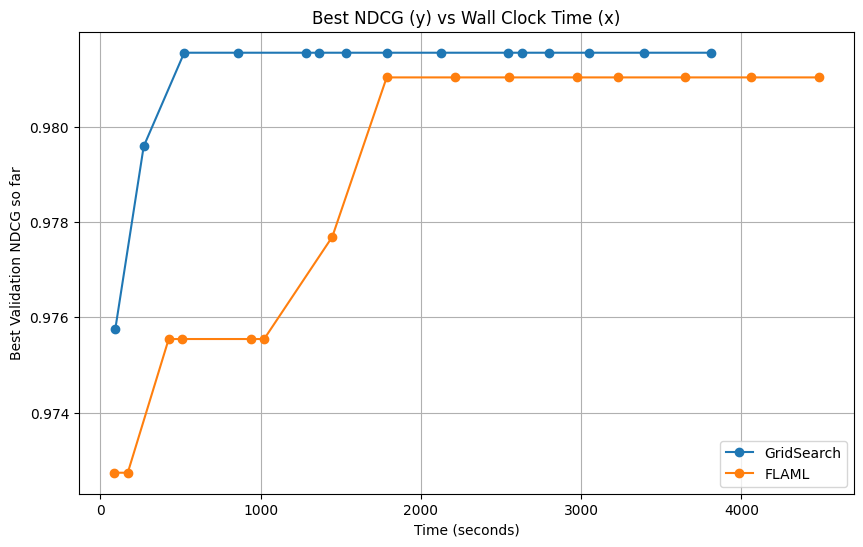

In [31]:
# graph
import matplotlib.pyplot as plt

def prepare_plot_xy(result, ndcg_key="best_ndcg"):
  wct = [r["wct"] for r in result]
  x = np.cumsum(wct)
  scores = [r[ndcg_key] if ndcg_key in r else r["ndcg"] for r in result]
  y = np.maximum.accumulate(scores)
  return x, y

x_grid = [r["wct"] for r in grid_result]
y_grid = np.maximum.accumulate([r["best_ndcg"] for r in grid_result])
x_flaml, y_flaml = prepare_plot_xy(flaml_result, ndcg_key="ndcg")

plt.figure(figsize=(10, 6))

plt.plot(x_grid, y_grid, '-o', label="GridSearch")
plt.plot(x_flaml, y_flaml, '-o', label="FLAML")

plt.xlabel("Time (seconds)")
plt.ylabel("Best Validation NDCG so far")
plt.title("Best NDCG (y) vs Wall Clock Time (x)")
plt.legend()
plt.grid(True)

plt.show()
